# Behavioral Clonning
The goal of the following project is to develop a deep neural network to learn how to drive a simulated car.

## Load Images File

This file pre process the data image and CSV generated by the simulator. Udacity provided a data package, which can be download in [this link](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip) containing the following files:
* Folder with 8.036 simulation images, showing the center, left and right camera view of the road, totalizing 24.108 images
* File <em>driving\_log.csv</em> containing a list describing all the images
    * Center image path
    * Left image path
    * Right image path
    * Steering angle
    * Throttle
    * Brake
    * Speed

Bellow are some examples of the images provided by Udacity and how it is shown in the _csv_ file:


IMG/center_2016_12_01_13_30_48_287.jpg, IMG/left_2016_12_01_13_30_48_287.jpg, IMG/right_2016_12_01_13_30_48_287.jpg, 0, 0, 0, 22.14829

* Center image path - IMG/center_2016_12_01_13_30_48_287.jpg
* Left image path - IMG/left_2016_12_01_13_30_48_287.jpg
* Right image path - IMG/right_2016_12_01_13_30_48_287.jpg
* Steering angle - 0
* Throttle - 0
* Brake - 0
* Speed - 22.14829


Images mapped with 8043 examples


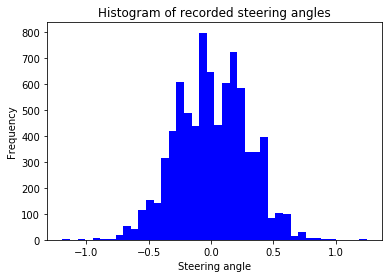

In [1]:
'''
    Read driving_log.csv and save it in a vector with the following configuration:
        * Image path
        * Steering angle
        * Throttle
        * Brake
        * Speed
'''

import csv
import numpy as np

list_images = list()

# The following value is added and subtracted from the steering angle for the images of the right and left side of the car
offset = 0.25

import random
bias = 0.5

with open('data\driving_log.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        steering = float(row[3])
        throttle = float(row[4])
        brake = float(row[5])
        speed = float(row[6])

#         if (steering == 0):
#             if (np.random.rand() > 0.9999):
#                 # Center image
#                 list_images.append([row[0].replace(" ", ""), steering, throttle, brake, speed])
#         else:
#         if (steering != 0):
#             if (np.random.rand() > 0.0):
        if np.random.rand() > 0.0:
            steering_thresh = np.random.rand()
            if (abs(steering) + bias) < steering_thresh:
                pass # drop this sample
            else:
                if (steering == 0):
                    if (np.random.rand() > 0.85):
                        # Center image
                        list_images.append([row[0].replace(" ", ""), steering, throttle, brake, speed])
                        # Left image
                        list_images.append([row[1].replace(" ", ""), steering + offset, throttle, brake, speed])
                        # Right image
                        list_images.append([row[2].replace(" ", ""), steering - offset, throttle, brake, speed])
                else:
                    # Center image
                    list_images.append([row[0].replace(" ", ""), steering, throttle, brake, speed])
                    # Left image
                    list_images.append([row[1].replace(" ", ""), steering + offset, throttle, brake, speed])
                    # Right image
                    list_images.append([row[2].replace(" ", ""), steering - offset, throttle, brake, speed])
        
print('Images mapped with {} examples'.format(len(list_images)))

import matplotlib.pyplot as plt
%matplotlib inline

histogram = [x[1] for x in list_images]

plt.hist(histogram, bins = 40, facecolor='blue');
plt.xlabel('Steering angle');
plt.ylabel('Frequency');
plt.title('Histogram of recorded steering angles');

### Ploting histogram
In order to analyze the angles distribution of our dataset, a histogram is plotted bellow. Here is possible to see that a higher number of small steerings is presented in the dataset, with a higher number of three especific angle band.

## Image Augmentation
In order to generate more data without the necessity of collectiong it, it is possible to apply some transformations.

In [2]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import random
%matplotlib inline

def plot_image_prob(image):
    fig = plt.figure(facecolor="white")
    ax = fig.add_subplot(111)
    ax.imshow(image, vmin=0, vmax=255)
    plt.axis('off')
    ax.axis('tight')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

def flip_image(img, steering):
    if random.randint(0, 1):
        return cv2.flip(img, 1), -steering
    else:
        return img, steering
    
def brightness_image(img, steering):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv[:,:,2] = hsv[:,:,2] * random.uniform(0.3, 1.2)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR), steering

def rotate_image(img, steering):
    rows,cols,channel = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), random.uniform(-5, 5), 1)
    return cv2.warpAffine(img,M,(cols,rows)), steering

def cut_image(img):
    rows,cols,channel = img.shape
    top = int(.4 * rows)
    botton = int(.85 * rows)
    border = int(.05 * cols)
    return img[top:botton, border:cols-border, :]

def translate_image(img, steering, horz_range=30, vert_range=5):
    rows, cols, chs = img.shape
    tx = np.random.randint(-horz_range, horz_range+1)
    ty = np.random.randint(-vert_range, vert_range+1)
    steering = steering + tx * 0.004 # mul by steering angle units per pixel
    tr_M = np.float32([[1,0,tx], [0,1,ty]])
    img = cv2.warpAffine(img, tr_M, (cols,rows), borderMode=1)
    return img, steering

# example = list_images[random.randint(0,len(list_images))]
# image = Image.open("data/" + example[0])
# print("Original shape: {}".format(image.size))
# new_image, new_steering = rotate_image(np.copy(image), example[1])
# cutted_image = cut_image(new_image)
# print("New shape: {}".format(cutted_image.shape))
# print("Old steering: {}".format(example[1]))
# print("New steering: {}".format(new_steering))
# plot_image_prob(image)
# plot_image_prob(new_image)
# plot_image_prob(cutted_image)

## Load the data
The data will not be entirely loaded to the memory because the dataset is too big, so a function *load_data* is created in order to load the data as it is needed.

In [3]:
import progressbar
import pickle
import os.path

def load_data(list_images):
    # Placeholders for the images and labels from web
    X = np.empty(shape = [1, 320, 160, 3], dtype = np.uint8)
    y = np.empty(shape = [1], dtype = np.float32)
    
    bar = progressbar.ProgressBar()
    for i in bar(range(len(list_images))):
        image = Image.open("data/" + list_images[i][0])
        steering = list_images[i][1]

        X = np.vstack([X, np.reshape(image, [1, 320, 160, 3])])
        y = np.vstack([y, steering])

        image, steering = flip_image(np.copy(image), steering)

        X = np.vstack([X, np.reshape(image, [1, 320, 160, 3])])
        y = np.vstack([y, steering])
    
    # Get rid of the first empty row
    X = X[1:, :, :, :]
    y = y[1:]

    return X, y

def load_data_batch(list_images, indices):
    # Placeholders for the images and labels from web
    X = np.empty(shape = [1, 320, 160, 3], dtype = np.uint8)
    y = np.empty(shape = [1], dtype = np.float32)

    for i in indices:
        image = Image.open("data/" + list_images[i][0])
        steering = list_images[i][1]

        X = np.vstack([X, np.reshape(image, [1, 320, 160, 3])])
        y = np.vstack([y, steering])
    
    # Get rid of the first empty row
    X = X[1:, :, :, :]
    y = y[1:]

    return X, y

In [ ]:
file = "data.p" # File name

# If file exists read, if not, create file
if (os.path.isfile(file)):
    with open(file, mode='rb') as f:
        data = pickle.load(f)
    
    X, y = data['images'], data['steering']
    print("File already in disk! Images loaded\n")
else:
    # print("Creating image file")
    X, y = load_data(list_images)

    # Save file to 
    d = {'images': X, 'steering': y}

    output = open('data.p', 'wb')
    pickle.dump(d, output)
    output.close()
    
# Convert data to float
X = X.astype('float32')
y = y.astype('float32')

print("X_train shape =", X.shape)
print("y_train shape =", y.shape)

In [ ]:
plt.hist(y, bins = 40, facecolor='blue');
plt.xlabel('Steering angle');
plt.ylabel('Frequency');
plt.title('Histogram of recorded steering angles');

## Neural network implementation
Bellow will be implemented the network network, which is based on the paper released by NVIDIA.

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, Flatten, Activation, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

model = Sequential()

# Layer 1: Input: 72 x 288 x 3 - Output: 35 x 143 x 24
model.add(Convolution2D(24, 5, 5, input_shape=(64, 64, 3), border_mode='same', init='normal'))
model.add(Activation('elu'))
model.add(MaxPooling2D((2, 2)))
#model.add(BatchNormalization())

# Layer 2: Input: 72 x 288 x 3 - Output: 35 x 143 x 24
model.add(Convolution2D(36, 5, 5, init='normal'))
model.add(Activation('elu'))
model.add(MaxPooling2D((2, 2)))
#model.add(BatchNormalization())

# Layer 3: Input: 72 x 288 x 3 - Output: 35 x 143 x 24
model.add(Convolution2D(48, 5, 5, init='normal'))
model.add(Activation('elu'))
model.add(MaxPooling2D((2, 2)))
#model.add(BatchNormalization())

# Layer 4: Input: 72 x 288 x 3 - Output: 35 x 143 x 24
model.add(Convolution2D(64, 3, 3, init='normal'))
model.add(Activation('elu'))
#model.add(BatchNormalization())

# Layer 5: Input: 72 x 288 x 3 - Output: 35 x 143 x 24
model.add(Convolution2D(64, 3, 3, init='normal'))
model.add(Activation('elu'))
#model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(100, init='normal'))
model.add(Dropout(p=0.5))
model.add(Activation('elu'))

model.add(Dense(50, init='normal'))
model.add(Dropout(p=0.5))
model.add(Activation('elu'))

model.add(Dense(10, init='normal'))
model.add(Dropout(p=0.5))
model.add(Activation('elu'))

model.add(Dense(1, init='normal'))

print(model.summary())

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 64, 64, 24)    1824        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 64, 64, 24)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 32, 24)    0           activation_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 28, 28, 36)    21636       maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [6]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Shuffle list
list_images = shuffle(list_images)

# Split testing set
train_set, valid_set = train_test_split(list_images, test_size=0.2, random_state=0)

print("Train set =", len(train_set))
print("Validation set =", len(valid_set))

# # Shuffle list
# X, y = shuffle(X, y)

# # Split testing set
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

# print("X_train shape =", X_train.shape)
# print("y_train shape =", y_train.shape)
# print("X_valid shape =", X_valid.shape)
# print("y_valid shape =", y_valid.shape)

Train set = 6434
Validation set = 1609


In [ ]:
# histogram = y_train

# plt.hist(histogram, 100, facecolor='blue');
# plt.xlabel('Steering angle');
# plt.ylabel('Frequency');
# plt.title('Histogram of recorded steering angles');

In [ ]:
bias = 0.3
histogram = list()
for steering in y_train:
    steering_thresh = np.random.rand()
    if (abs(steering) + bias) > steering_thresh:   
        histogram.append(steering[0])

plt.hist(histogram, 100, facecolor='blue');
plt.xlabel('Steering angle');
plt.ylabel('Frequency');
plt.title('Histogram of recorded steering angles');

In [8]:
def myGenerator(X, y, batch_size, flag="test"):
    while 1:
        X, y = shuffle(X, y)

        for batch_ind in range(0, len(X), batch_size):

            X_batch = np.empty(shape = [1, 288, 72, 3], dtype = np.uint8)
            y_batch = np.empty(shape = [1], dtype = np.float32)

            for i in range(batch_ind, min(batch_ind + batch_size, len(X))):

                image = X[i]
                steering = y[i]

                if (flag == "test"):
                    image, steering = brightness_image(np.copy(image), steering)
                    image, steering = rotate_image(np.copy(image), steering)
                    image, steering = translate_image(np.copy(image), steering)
                    
                image = cut_image(image)

                image = (image - 128.0) / 128.0

                X_batch = np.vstack([X_batch, np.reshape(image, [1, 288, 72, 3])])
                y_batch = np.vstack([y_batch, steering])

            # Get rid of the first empty row
            X_batch = X_batch[1:, :, :, :]
            y_batch = y_batch[1:]

            yield (X_batch, y_batch)
            
def myGenerator2(list, batch_size, flag="test"):
    while 1:
        list = shuffle(list)

        X_batch = np.empty(shape = [1, 64, 64, 3], dtype = np.uint8)
        y_batch = np.empty(shape = [1], dtype = np.float32)
        
        X, y = load_data_batch(list, random.sample(range(len(list)), batch_size))

        for i in range(len(X)):

            image = X[i]
            steering = y[i]

            if (flag == "test"):
                image, steering = brightness_image(np.copy(image), steering)
                image, steering = rotate_image(np.copy(image), steering)
                image, steering = translate_image(np.copy(image), steering)
                image, steering = flip_image(np.copy(image), steering)

            image = cut_image(image)

            image = (image - 128.0) / 128.0

            X_batch = np.vstack([X_batch, np.reshape(image, [1, 64, 64, 3])])
            y_batch = np.vstack([y_batch, steering])

        # Get rid of the first empty row
        X_batch = X_batch[1:, :, :, :]
        y_batch = y_batch[1:]

        yield (X_batch, y_batch)
# generator = myGenerator(X_valid, y_valid, 40)
# a, b = next(generator)#generator.fit()
# print(a.shape)
# print(b.shape)

In [12]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# compile and fit model
print("Fitting model")
model.compile(loss='mse', metrics=['mse'], optimizer=Adam(lr=0.001))

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=2, verbose=1)
model_checkpoint = ModelCheckpoint(filepath='model.weights.{epoch:02d}-{val_loss:.5f}.h5', verbose=1, save_best_only=True, save_weights_only=True)
learning_rate_plateau_reducer = ReduceLROnPlateau(verbose=1, patience=0, epsilon=1e-5)

batch_size=40

fit = model.fit_generator(myGenerator2(train_set, batch_size),
                          verbose=1, samples_per_epoch=2000,
                          nb_epoch=5,
                          #callbacks=[model_checkpoint, learning_rate_plateau_reducer, early_stopping],
                          validation_data=myGenerator2(valid_set, batch_size, "validation"),
                          nb_val_samples = 2000)

# fit = model.fit_generator(myGenerator(X_train, y_train, batch_size),
#                           verbose=1, samples_per_epoch=len(X_train),
#                           nb_epoch=5,
#                           #callbacks=[model_checkpoint, learning_rate_plateau_reducer, early_stopping],
#                           validation_data=myGenerator(X_valid, y_valid, batch_size, "validation"),
#                           nb_val_samples = len(X_valid))

Fitting model
Epoch 1/5


Exception in thread Thread-7:
Traceback (most recent call last):
  File "C:\Users\Ibis\Anaconda3\envs\tensorflow-gpu\lib\threading.py", line 914, in _bootstrap_inner
    self.run()
  File "C:\Users\Ibis\Anaconda3\envs\tensorflow-gpu\lib\threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Ibis\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\engine\training.py", line 429, in data_generator_task
    generator_output = next(self._generator)
  File "<ipython-input-8-b49802844c83>", line 57, in myGenerator2
    X_batch = np.vstack([X_batch, np.reshape(image, [1, 64, 64, 3])])
  File "C:\Users\Ibis\Anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\core\fromnumeric.py", line 224, in reshape
    return reshape(newshape, order=order)
ValueError: total size of new array must be unchanged



ValueError: output of generator should be a tuple (x, y, sample_weight) or (x, y). Found: None

In [ ]:
# scores = model.evaluate(myGenerator(X_valid, y_valid, batch_size, "validation"), verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# compare model predicted steering angles with labeled values
# y_train_predict = model.predict(X_train)
# print(y_train_predict.shape)

# evaluate the model
# np.set_printoptions(suppress=True)
# print(y_train_predict[0:40].T)
# print(y_train[0:40].T)

# output model
print("Saving model structure and weights")
model_json = model.to_json()
import json
with open ('model.json', 'w') as f:
    json.dump(model_json, f, indent=4, sort_keys=True, separators=(',', ':'))

model.save_weights('model.h5')

# Not using anymore

In [ ]:
# fit = model.fit(X_train, y_train, nb_epoch=10, batch_size=40, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint, learning_rate_plateau_reducer, early_stopping])

#  samples_per_epoch=1000

In [ ]:
# def load_data(list_images):
#     # Placeholders for the images and labels from web
#     X_train = np.empty(shape = [1, 320, 160, 3], dtype = np.uint8)
#     y_train = np.empty(shape = [1], dtype = np.float32)
#     i = 1

#     for data in list_images:
#         image = Image.open("data/" + data[0])
#         steering = data[1]

#         X_train = np.vstack([X_train, np.reshape(image, [1, 320, 160, 3])])
#         y_train = np.vstack([y_train, steering])
        
#         image, steering = flip_image(np.copy(image), steering)
        
#         X_train = np.vstack([X_train, np.reshape(image, [1, 320, 160, 3])])
#         y_train = np.vstack([y_train, steering])
        
#         i += 1
#         print(str(i) + "/" + str(len(list_images)))
    
#     # Get rid of the first empty row
#     X_train = X_train[1:, :, :, :]
#     y_train = y_train[1:]

#     return X_train, y_train

# def load_data_valid(list_images):
#     # Placeholders for the images and labels from web
#     X_train = np.empty(shape = [1, 288, 72, 3], dtype = np.uint8)
#     y_train = np.empty(shape = [1], dtype = np.float32)
    
#     i = 0
    
#     for data in list_images:
#         image = Image.open("data/" + data[0])
#         steering = data[1]

#         image = cut_image(np.copy(image))

#         image = (image - 128.0) / 128.0
        
#         X_train = np.vstack([X_train, np.reshape(image, [1, 288, 72, 3])])
#         y_train = np.vstack([y_train, steering])
        
#         image, steering = flip_image(np.copy(image), steering)
        
#         X_train = np.vstack([X_train, np.reshape(image, [1, 288, 72, 3])])
#         y_train = np.vstack([y_train, steering])
        
#         i += 1
#         print(str(i) + "/" + str(len(list_images)))
    
    
#     # Get rid of the first empty row
#     X_train = X_train[1:, :, :, :]
#     y_train = y_train[1:]

#     return X_train, y_train

# # from random import randint

# # indices = random.sample(range(0, len(list_images)), 21)
# # X_train, y_train = load_data(list_images, indices)
# # #print(y_train)
                
# # # Plot an example of images processed
# # fig = plt.figure(facecolor="white");
# # fig.set_size_inches(15, 4);
# # fig.subplots_adjust(hspace=.5);

# # for i in range(21):    
# #     ax=fig.add_subplot(3, 7, i+1);    
# #     ax.imshow(np.reshape(X_train[i], [72, 288, 3]), vmin=0, vmax=255);
# #     ax.axis('off');
# #     ax.set_title("Steering: {0:.2f}".format(y_train[i][0]), fontsize = 10);
# #     ax.axis('tight');
# # plt.suptitle('Image examples with augmentation');